In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time 

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

from p5_cleaning_functions import clean_orders, get_customers

sns.set()

In [2]:
# Chargement du fichier de commandes
orders, customers = clean_orders()

Ouverture des fichiers...
Nettoyage des dataset individuels...
Merge des dataset pour reconstitution du dataset des commandes...
Début du feature engineering...
Création du fichier client...
Fin du traitement
Temps écoule : 28.2s


#### Modèle initial

In [3]:
# Nombre de clusters retenu
n_clusters = 5

# On récupère les clients des 500 premiers jours
customers_init = get_customers(orders, customers, start=0, stop=500)

# On sélectionne les features pertinentes au clustering
cols = ["most_recent_purchase", "nb_orders", "nb_items", "amount_spent", 
        "review_score"]
X_init = customers_init.loc[:, cols].sort_index()

# Nombre de clients des 500 premiers jours
n_init = X_init.shape[0]

# On normalise le dataset
scaler_init = StandardScaler()
X_init_scaled = scaler_init.fit_transform(X_init)

# On entraine le modèle sur la base de clients à stop = 500 jours
model_init = KMeans(n_clusters=n_clusters)
model_init.fit(X_init_scaled)

Création du fichier client...
Fin du traitement
Temps écoule : 0.1s


KMeans(n_clusters=5)

#### Comparasion des résultats entre le modèle initial et le modèle actualisé

In [4]:
ari = []
for t in range(515,721,15):
    
    # Labels avec modèle actualisé
    customers_t = get_customers(orders, customers, start=0, stop=t)
    X = customers_t.loc[:, cols]
    print(f"\nstop = {t} jours")
    print(f"Clients supplémentaires depuis la dernière segmentation:", 
          X.shape[0]-n_init)
    model = Pipeline([("preprocessing", StandardScaler()), 
                      ("model", KMeans(n_clusters=n_clusters))])
    model.fit(X)
    X["labels"] = model["model"].labels_
    X = X.loc[X.index.isin(customers_init.index), :].sort_index()
    labels = X["labels"]
    
    # Labels avec modèle initial
    mask = customers_t.index.isin(customers_init.index)
    X_t0 = customers_t.loc[mask, cols].sort_index()
    X_t0_scaled = scaler_init.transform(X_t0)
    labels_t0 = model_init.predict(X_t0_scaled)
    
    ari.append(adjusted_rand_score(labels, labels_t0))

Création du fichier client...
Fin du traitement
Temps écoule : 0.1s

stop = 515 jours
Clients supplémentaires depuis la dernière segmentation: 3155
Création du fichier client...
Fin du traitement
Temps écoule : 0.1s

stop = 530 jours
Clients supplémentaires depuis la dernière segmentation: 6614
Création du fichier client...
Fin du traitement
Temps écoule : 0.1s

stop = 545 jours
Clients supplémentaires depuis la dernière segmentation: 10077
Création du fichier client...
Fin du traitement
Temps écoule : 0.1s

stop = 560 jours
Clients supplémentaires depuis la dernière segmentation: 13451
Création du fichier client...
Fin du traitement
Temps écoule : 0.1s

stop = 575 jours
Clients supplémentaires depuis la dernière segmentation: 16579
Création du fichier client...
Fin du traitement
Temps écoule : 0.1s

stop = 590 jours
Clients supplémentaires depuis la dernière segmentation: 19964
Création du fichier client...
Fin du traitement
Temps écoule : 0.1s

stop = 605 jours
Clients supplémentaire

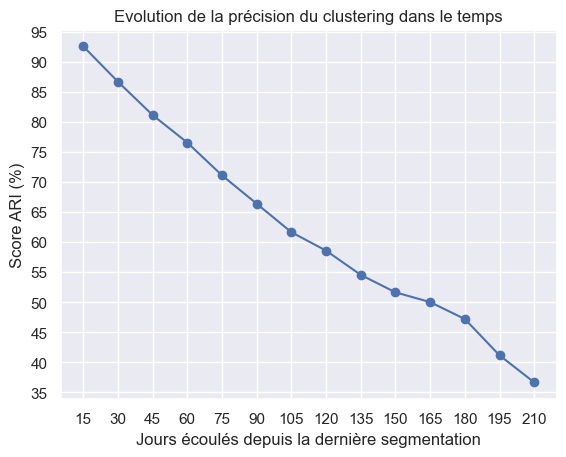

In [5]:
plt.plot(range(15,221,15), list(map(lambda x:100*x, ari)), marker='o')
plt.xticks(range(15,221,15))
plt.yticks(range(35,96,5))
plt.xlabel("Jours écoulés depuis la dernière segmentation")
plt.ylabel("Score ARI (%)")
plt.title("Evolution de la précision du clustering dans le temps")
plt.show()

#### Conclusion : On cherche à avoir un ARI supérieur à 80%. D'après le graphe ci-dessus, il faudrait donc réaliser un nouveau clustering tous les 60 jours, soit 2 mois.